# Problem Statement

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

# Objective

Company want to understand the factors affecting the demand for these shared bikes in the American market. They wants to know:

 - Which variables are significant in predicting the demand for shared bikes.
 - How well those variables describe the bike demands

# Business Goal

To model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

## Data Sourcing

The company already given the data set containing the information about the bike sharing for year 2018 and 2019.
For this case study we need to focus only on provided dataset given by company.

## Import libraries

In [325]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Read and store data

In [327]:
path_to_dataset = '/kaggle/input/boom-bike-dataset/bike_sharing_data.csv'
bike_ds = pd.read_csv(path_to_dataset, header=0)

In [328]:
# Shape of bike sharing dataset
rows = bike_ds.shape[0]
columns = bike_ds.shape[1]
print('Total number of Rows : ', rows)
print('Total number of Columns : ', columns)

Total number of Rows :  730
Total number of Columns :  16


In [329]:
# setting to display all rows & columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [330]:
bike_ds.head(8)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959


## Data Dictionary

- **instant**: record index
- **dteday** : date
- **season** : season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2018, 1: 2019)
- **mnth** : month ( 1 to 12)
- **holiday** : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0.
+ **weathersit** : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : temperature in Celsius
- **atemp**: feeling temperature in Celsius
- **hum**: humidity
- **windspeed**: wind speed
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

## Data Cleaning

- **instant** is just an index given in the dataset. we can get rid of this field.
- **weekday**, **mnth** and **yr** are already derived from **dteday**. Hence we can get rid of **dteday** field.
- There are two fields for temperature in dataset. **temp** and **atemp**. I am guessing, feeling temperature is more important for a person to choose bike as transporation medium. Hence we can get rid of **temp** field.
- **cnt** is our target variable for the model which is derived from **casual** and **registered** fields. Hence we can get rid of **casual** and **registered**.


Lets drop these fields from the dataset.

In [331]:
bike_ds.drop(['instant', 'dteday','casual','registered','temp'], axis=1, inplace=True)

In [332]:
bike_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


**Note**: Non null count is exactly equals to number of rows for every field. Hence there is no missing value in the data set.

## Identify Categorical variables

By looking at the data dictionary and available field now in the dataset, we can identify the categorical and numeric variables in the data set.

In [333]:
categorical_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
numeric_vars = ['atemp', 'hum', 'windspeed', 'cnt']

Lets convert dtype of categorical variables

In [334]:
bike_ds[categorical_vars] = bike_ds[categorical_vars].astype('category')

In [335]:
# Insight of numerical variables
bike_ds.describe()

,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000
mean,23.726322,62.765175,12.763620,4508.006849
std,8.150308,14.237589,5.195841,1936.011647
min,3.953480,0.000000,1.500244,22.000000
25%,16.889713,52.000000,9.041650,3169.750000
50%,24.368225,62.625000,12.125325,4548.500000
75%,30.445775,72.989575,15.625589,5966.000000
max,42.044800,97.250000,34.000021,8714.000000


In [336]:
# Insight of categorical variables
bike_ds.describe(include=['category'])

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730,730
unique,4,2,12,2,7,2,3
top,3,0,1,0,0,1,1
freq,188,365,62,709,105,499,463


## Lets map the categorical fields with more readable values

- **season**: 1: Spring, 2: Summer, 3: Fall, 4: Winter
- **yr**: 0: 2018, 1: 2019
- **mnth**: 1: Jan to 12: Dec
- **holiday**: 1: Holiday, 0: Non-Holiday
- **weekday**:  0: Sun, 1: Mon, 2: Tue, ..., 6: Sat
- **workingday**: 1: Working, 0- Non-working
- **weathersit**: 1: Clear, 2: Mist, 3: Light, 4: Heavy

In [337]:
# map the season column
bike_ds['season'] = bike_ds['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

# map the year column
bike_ds['yr'] = bike_ds['yr'].map({0: '2018', 1: '2019'})

# map mnth column
bike_ds['mnth'] = bike_ds['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12:'Dec'})

# map the holiday column
bike_ds['holiday'] = bike_ds['holiday'].map({1: 'Holiday', 0: 'Non-Holiday'})

# map the weekday column
bike_ds['weekday'] = bike_ds['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

# map the workingday column
bike_ds['workingday'] = bike_ds['workingday'].map({1: 'Working', 0: 'Non-Working'})

#  map weathersit column
bike_ds['weathersit'] = bike_ds['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light', 4: 'Heavy'})

In [338]:
bike_ds.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,Spring,2018,Jan,Non-Holiday,Sat,Non-Working,Mist,18.18125,80.5833,10.749882,985
1,Spring,2018,Jan,Non-Holiday,Sun,Non-Working,Mist,17.68695,69.6087,16.652113,801
2,Spring,2018,Jan,Non-Holiday,Mon,Working,Clear,9.47025,43.7273,16.636703,1349
3,Spring,2018,Jan,Non-Holiday,Tue,Working,Clear,10.60610,59.0435,10.739832,1562
4,Spring,2018,Jan,Non-Holiday,Wed,Working,Clear,11.46350,43.6957,12.522300,1600


In [339]:
bike_ds.shape

(730, 11)

## Exploratory Data Analysis

### Univariate Analysis
Lets visualize the count over the period of time

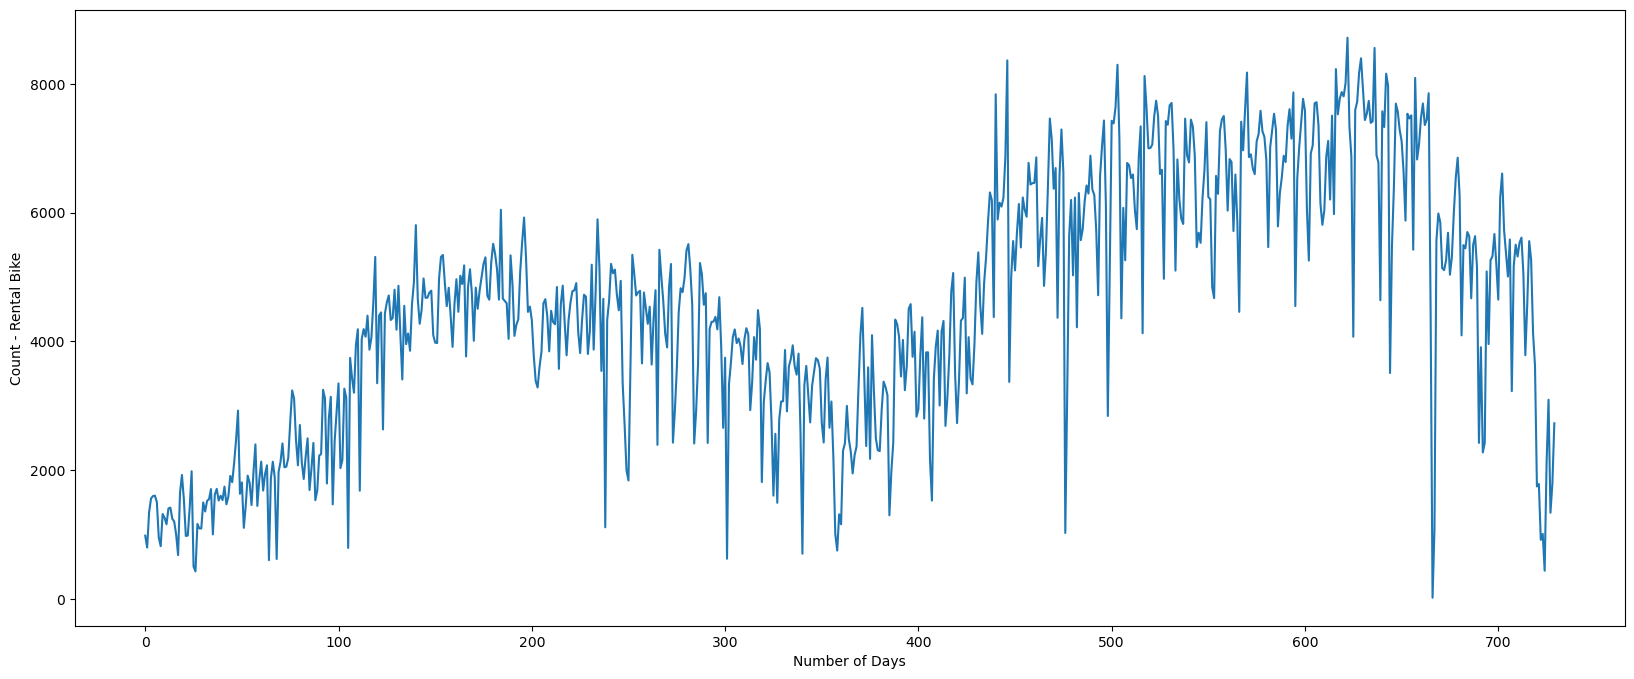

In [340]:
plt.figure(figsize=(20,8))
plt.plot(bike_ds.cnt)
plt.xlabel('Number of Days')
plt.ylabel('Count - Rental Bike')
plt.show()

**Insight**: count is increasing over the period of time and starts decreasing at the end of year.

### Outliear Analysis on numeric variables

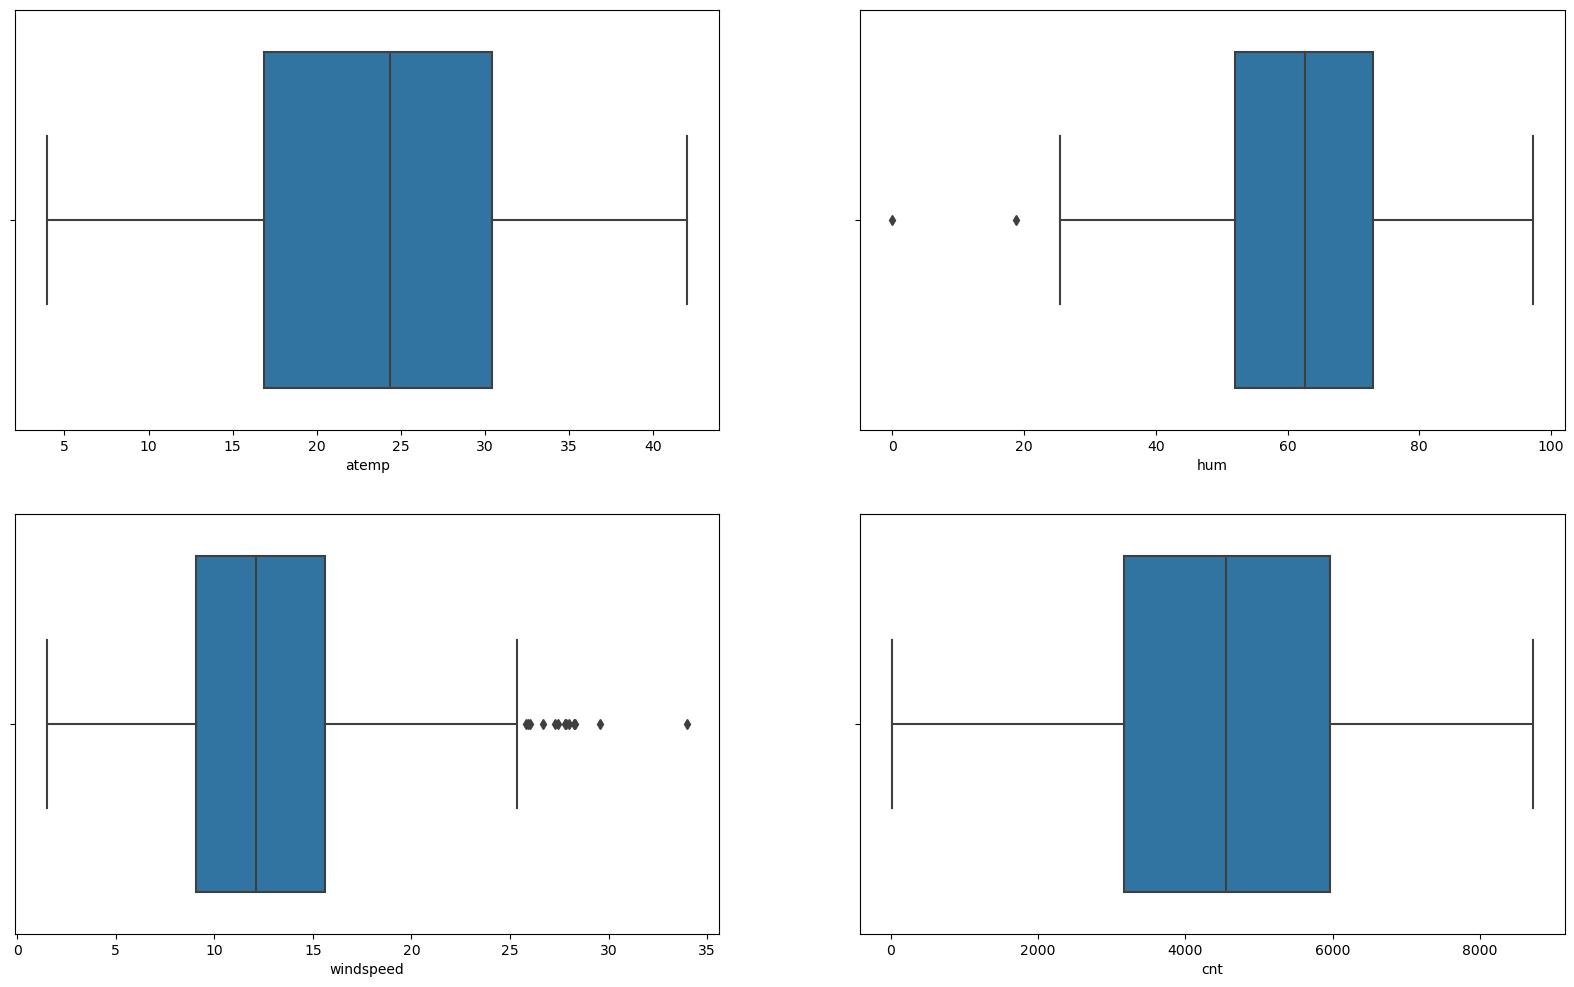

In [341]:
plt.figure(figsize=(20, 12))  
plt.subplot(2,2,1)
sns.boxplot(data=bike_ds, x='atemp')
plt.subplot(2,2,2)
sns.boxplot(data=bike_ds, x='hum')
plt.subplot(2,2,3)
sns.boxplot(data=bike_ds, x='windspeed')
plt.subplot(2,2,4)
sns.boxplot(data=bike_ds, x='cnt')
plt.show()

**Insight**: Few outliears present for windspeed field above 25 but less than 35.

In [342]:
bike_ds.windspeed.quantile(0.98)

25.201626559999998

In [343]:
# percentage of outliears
(bike_ds[(bike_ds.windspeed > bike_ds.windspeed.quantile(0.98))].shape[0]/rows)*100

2.054794520547945

**Insight**: Only 2% outliear present for windspeed field which lies between 25 and 35. This is small, will not impact the analysis. Hence not required to remove these ouliears.

### Bivariate Analysis

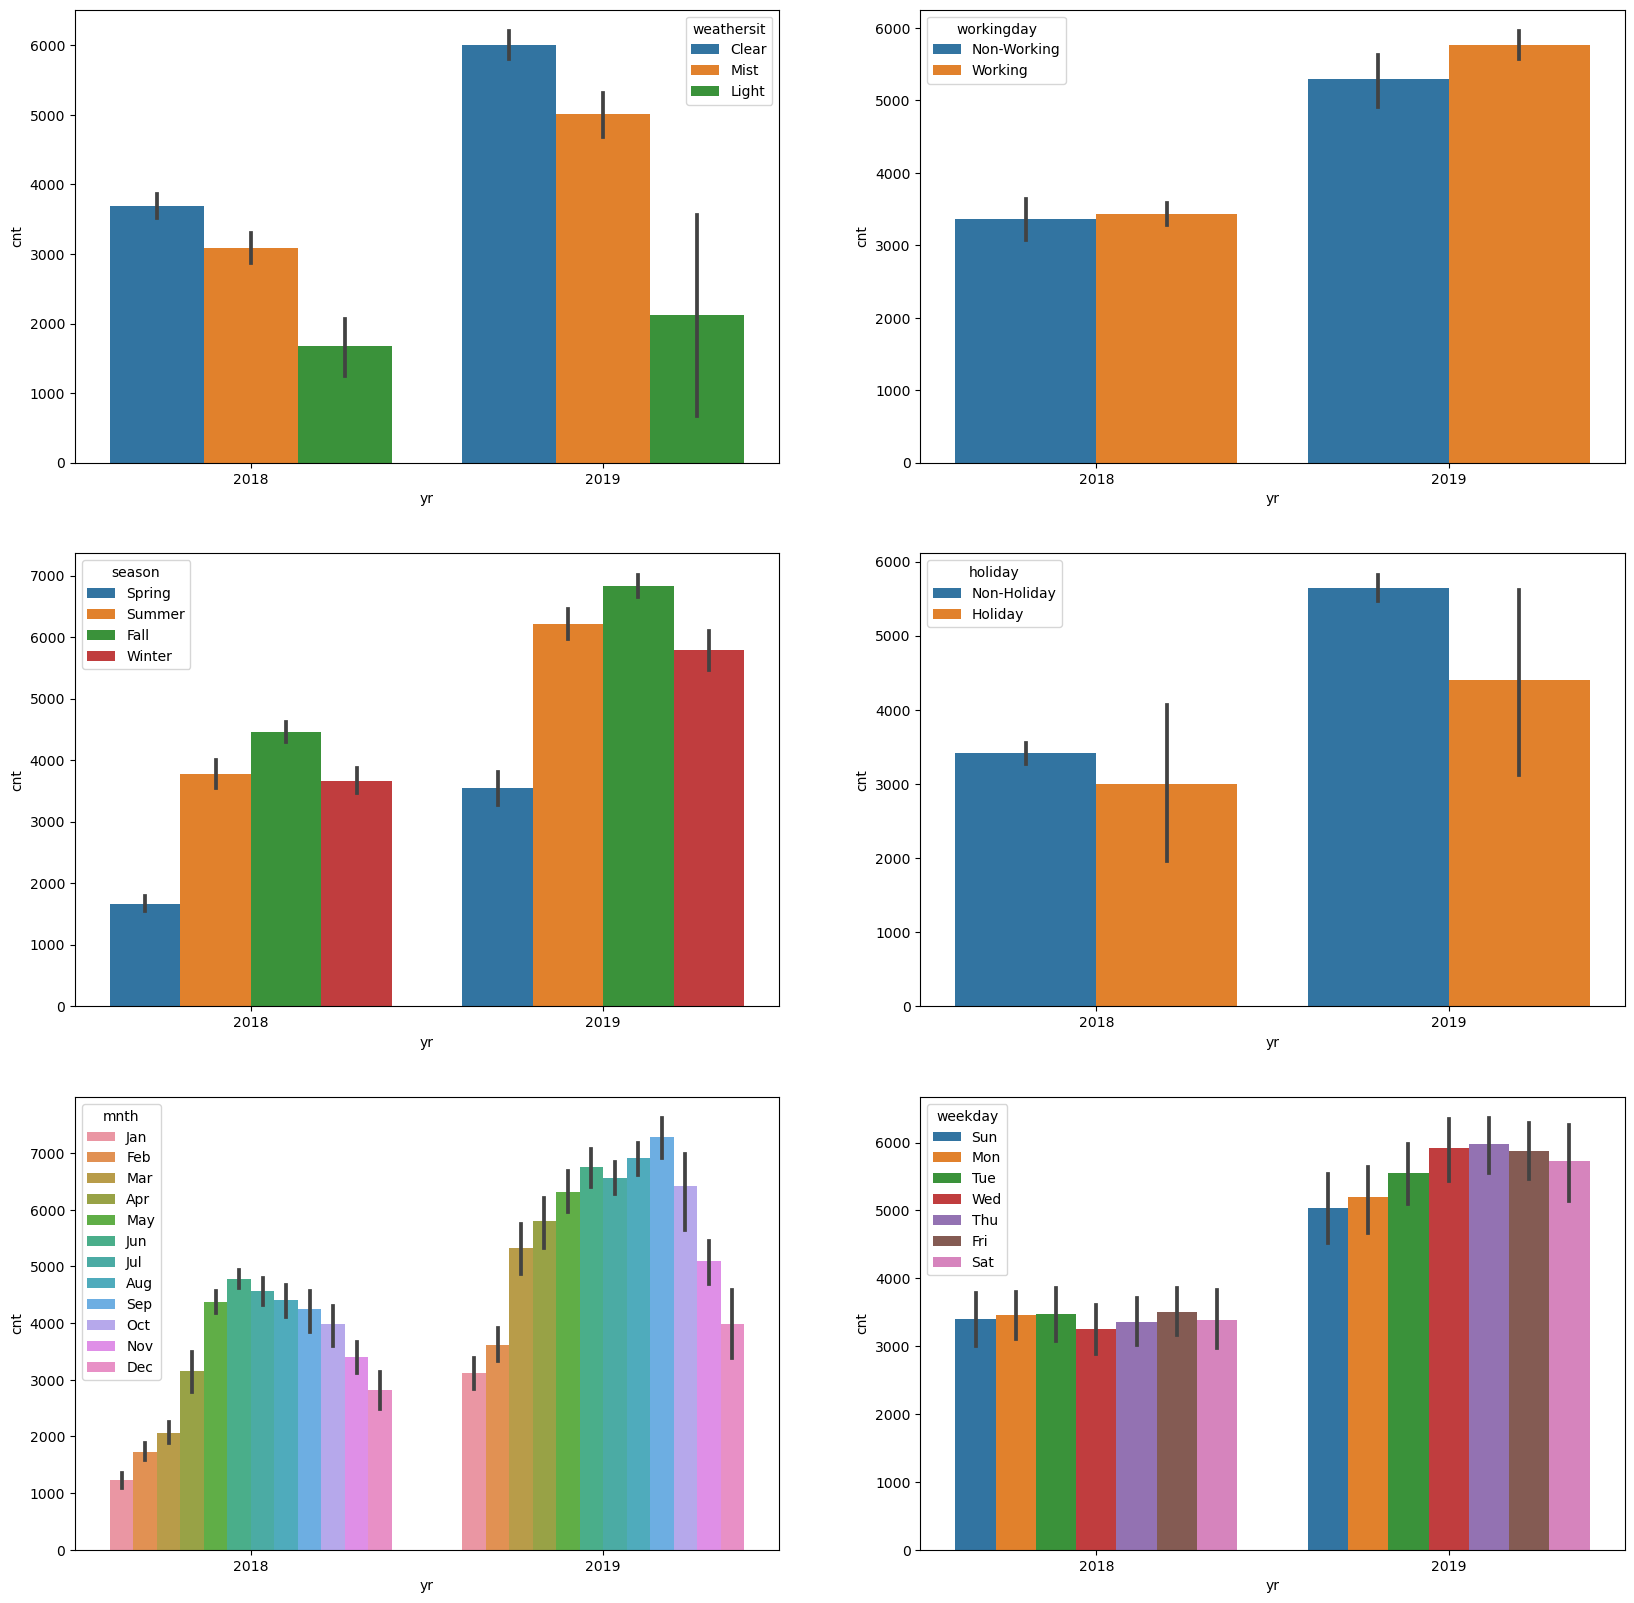

In [344]:
plt.figure(figsize=(20, 20))  
plt.subplot(3,2,1)
sns.barplot(data=bike_ds, x='yr', y='cnt', hue='weathersit')
plt.subplot(3,2,2)
sns.barplot(data=bike_ds, x='yr', y='cnt', hue='workingday')
plt.subplot(3,2,3)
sns.barplot(data=bike_ds, x='yr', y='cnt', hue='season')
plt.subplot(3,2,4)
sns.barplot(data=bike_ds, x='yr', y='cnt', hue='holiday')
plt.subplot(3,2,5)
sns.barplot(data=bike_ds, x='yr', y='cnt', hue='mnth')
plt.subplot(3,2,6)
sns.barplot(data=bike_ds, x='yr', y='cnt', hue='weekday')
plt.show()

**Insights**:
- Demand is high in clear and mist weather conditions. Highest demand is in clear weather condition.
- Demand is high on working days.
- Demand is high in spring, summer and fall season. Highest demand is in fall season.
- Demand is high in non holidays.
- Demand is hight from april to October.
- Demand is almost same on every day of the week.
- Demand is overall increases from 2018 to 2019.

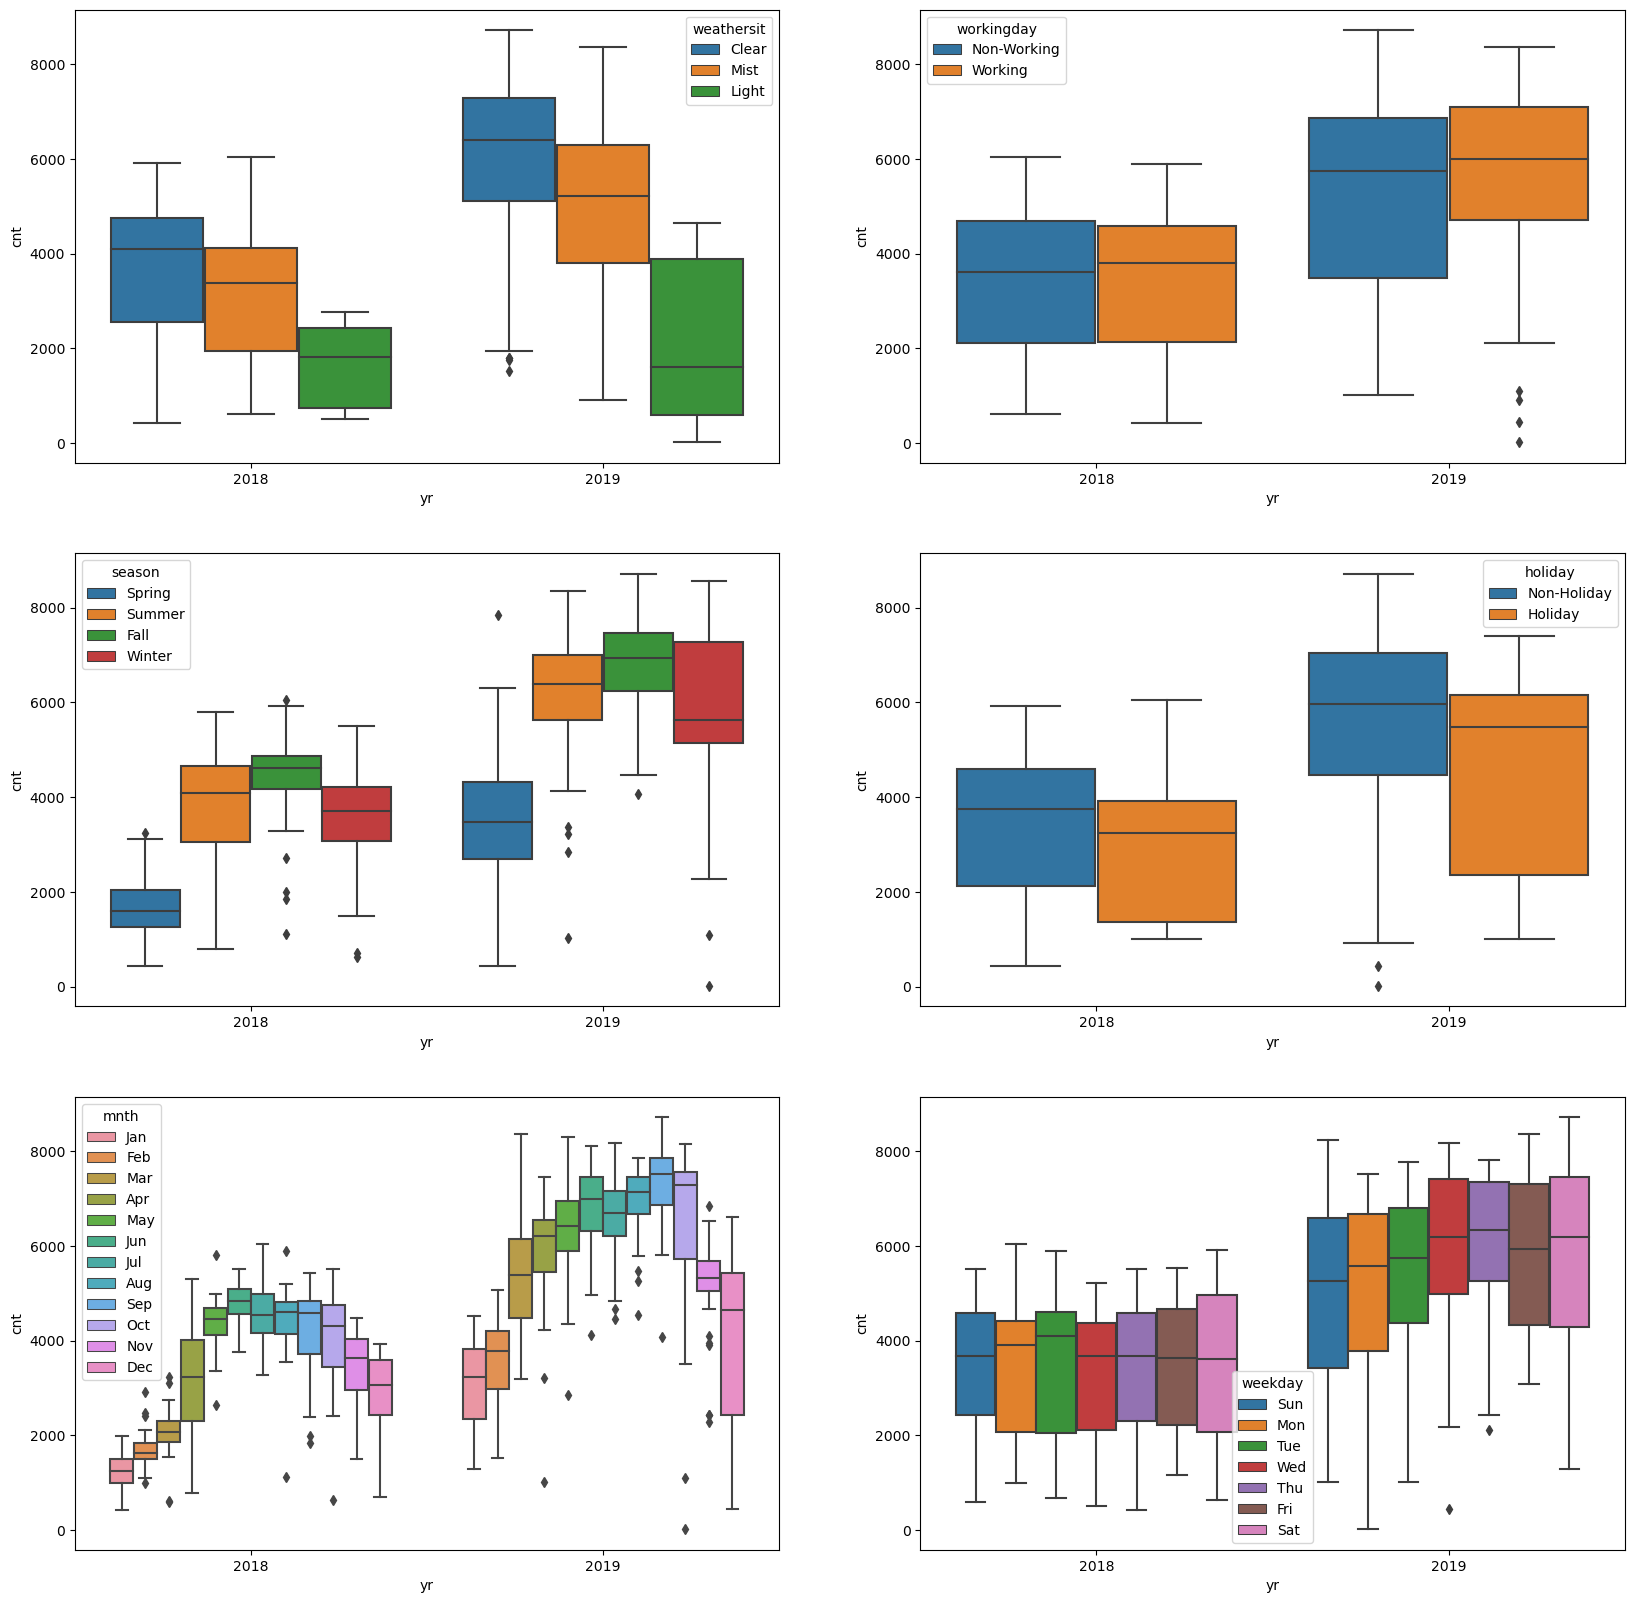

In [345]:
plt.figure(figsize=(20, 20))  
plt.subplot(3,2,1)
sns.boxplot(data=bike_ds, x='yr', y='cnt', hue='weathersit')
plt.subplot(3,2,2)
sns.boxplot(data=bike_ds, x='yr', y='cnt', hue='workingday')
plt.subplot(3,2,3)
sns.boxplot(data=bike_ds, x='yr', y='cnt', hue='season')
plt.subplot(3,2,4)
sns.boxplot(data=bike_ds, x='yr', y='cnt', hue='holiday')
plt.subplot(3,2,5)
sns.boxplot(data=bike_ds, x='yr', y='cnt', hue='mnth')
plt.subplot(3,2,6)
sns.boxplot(data=bike_ds, x='yr', y='cnt', hue='weekday')
plt.show()

**Insights**:
- Demand is high in clear and mist weather conditions. Highest demand is in clear weather condition.
- Demand is high on working days.
- Demand is high in spring, summer and fall season. Highest demand is in fall season.
- Demand is high in non holidays.
- Demand is hight from april to October.
- Demand is almost same on every day of the week.
- Demand is overall increases from 2018 to 2019.

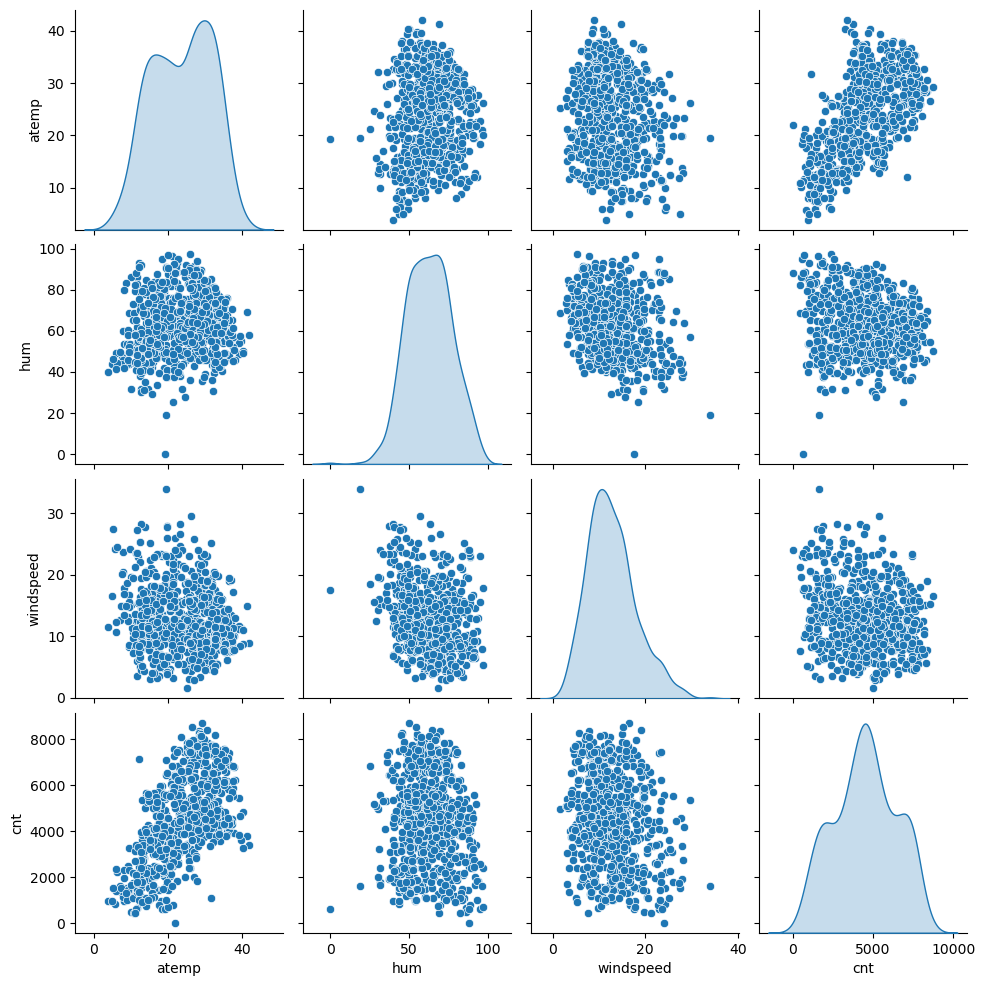

In [346]:
# pairplot for continuous data type
sns.pairplot(bike_ds.select_dtypes(['int64','float64']), diag_kind='kde')
plt.show()

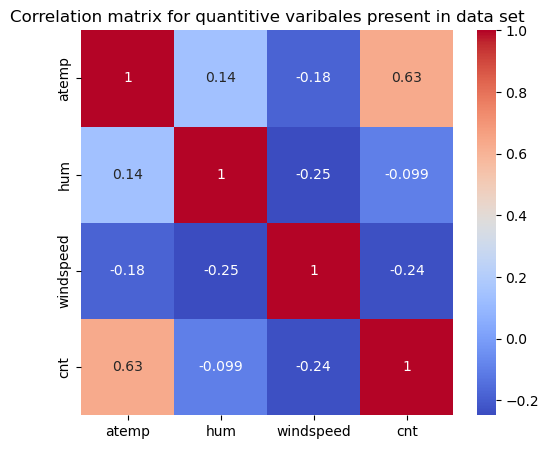

In [347]:
plt.figure(figsize=(6, 5))
sns.heatmap(data=bike_ds.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix for quantitive varibales present in data set')
plt.show()

**Insights**:
- **cnt** is positively correlated to **atemp** with correlation value equal to **0.63**. Degree of correlation is high.
- **cnt** is negatively correlated with **hum** and **windspeed** with correlation values **-0.099** and **-0.24** respectively. Degree of correlation is **moderate** with **windspeed** and almost **zero** with **hum**

## Data Prepration

In [348]:
# get dummy variables for season, weekday, mnth and weathersit
dummy_vars = pd.get_dummies(bike_ds[['season','weekday','mnth','weathersit']], drop_first=True)

# concat the dummy df with original df
bike_ds_2 = pd.concat([bike_ds,dummy_vars], axis = 1)

# drop season column
bike_ds_2.drop(['season','weekday','mnth','weathersit'], axis=1, inplace=True)

In [349]:
bike_ds_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   yr                730 non-null    category
 1   holiday           730 non-null    category
 2   workingday        730 non-null    category
 3   atemp             730 non-null    float64 
 4   hum               730 non-null    float64 
 5   windspeed         730 non-null    float64 
 6   cnt               730 non-null    int64   
 7   season_Summer     730 non-null    uint8   
 8   season_Fall       730 non-null    uint8   
 9   season_Winter     730 non-null    uint8   
 10  weekday_Mon       730 non-null    uint8   
 11  weekday_Tue       730 non-null    uint8   
 12  weekday_Wed       730 non-null    uint8   
 13  weekday_Thu       730 non-null    uint8   
 14  weekday_Fri       730 non-null    uint8   
 15  weekday_Sat       730 non-null    uint8   
 16  mnth_Feb          730 non-

**yr**, **holiday** and **workingday** are showing as category and their values are string. We need to remap these again to 0 and 1. Like it was in original data set otherwise linear regression model will not work.

In [350]:
# remap the year column
bike_ds_2['yr'] = bike_ds_2['yr'].map({'2018': 0, '2019': 1})

# remap the holiday column
bike_ds_2['holiday'] = bike_ds_2['holiday'].map({'Holiday': 1, 'Non-Holiday': 0})

# remap the workingday column
bike_ds_2['workingday'] = bike_ds_2['workingday'].map({'Working': 1, 'Non-Working': 0})

In [351]:
# Convert categorical columns to numeric 
bike_ds_2[['yr','holiday','workingday']]= bike_ds_2[['yr','holiday','workingday']].astype('uint8')

## Split the data into training and test set

In [352]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(bike_ds_2, train_size = 0.7, test_size = 0.3, random_state = 100)

In [353]:
print(df_train.shape)
print(df_test.shape)

(510, 29)
(219, 29)


### Scale the training data

 - Now that we have done the test-train split, we need to scale the variables for better interpretability. But we only need the scale the numeric columns and not the dummy variables.
 - We will use min max scaler

In [354]:
print(numeric_vars)

['atemp', 'hum', 'windspeed', 'cnt']


In [355]:
scaler = MinMaxScaler()

# fit and transform on training data
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_Summer,season_Fall,season_Winter,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,mnth_Feb,mnth_Mar,mnth_Apr,mnth_May,mnth_Jun,mnth_Jul,mnth_Aug,mnth_Sep,mnth_Oct,mnth_Nov,mnth_Dec,weathersit_Mist,weathersit_Light
653,1,0,1,0.501133,0.575354,0.300794,0.864243,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
576,1,0,1,0.766351,0.725633,0.264686,0.827658,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0,0.438975,0.640189,0.255342,0.465255,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
728,1,0,0,0.200348,0.498067,0.663106,0.204096,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
482,1,0,0,0.391735,0.504508,0.188475,0.482973,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0


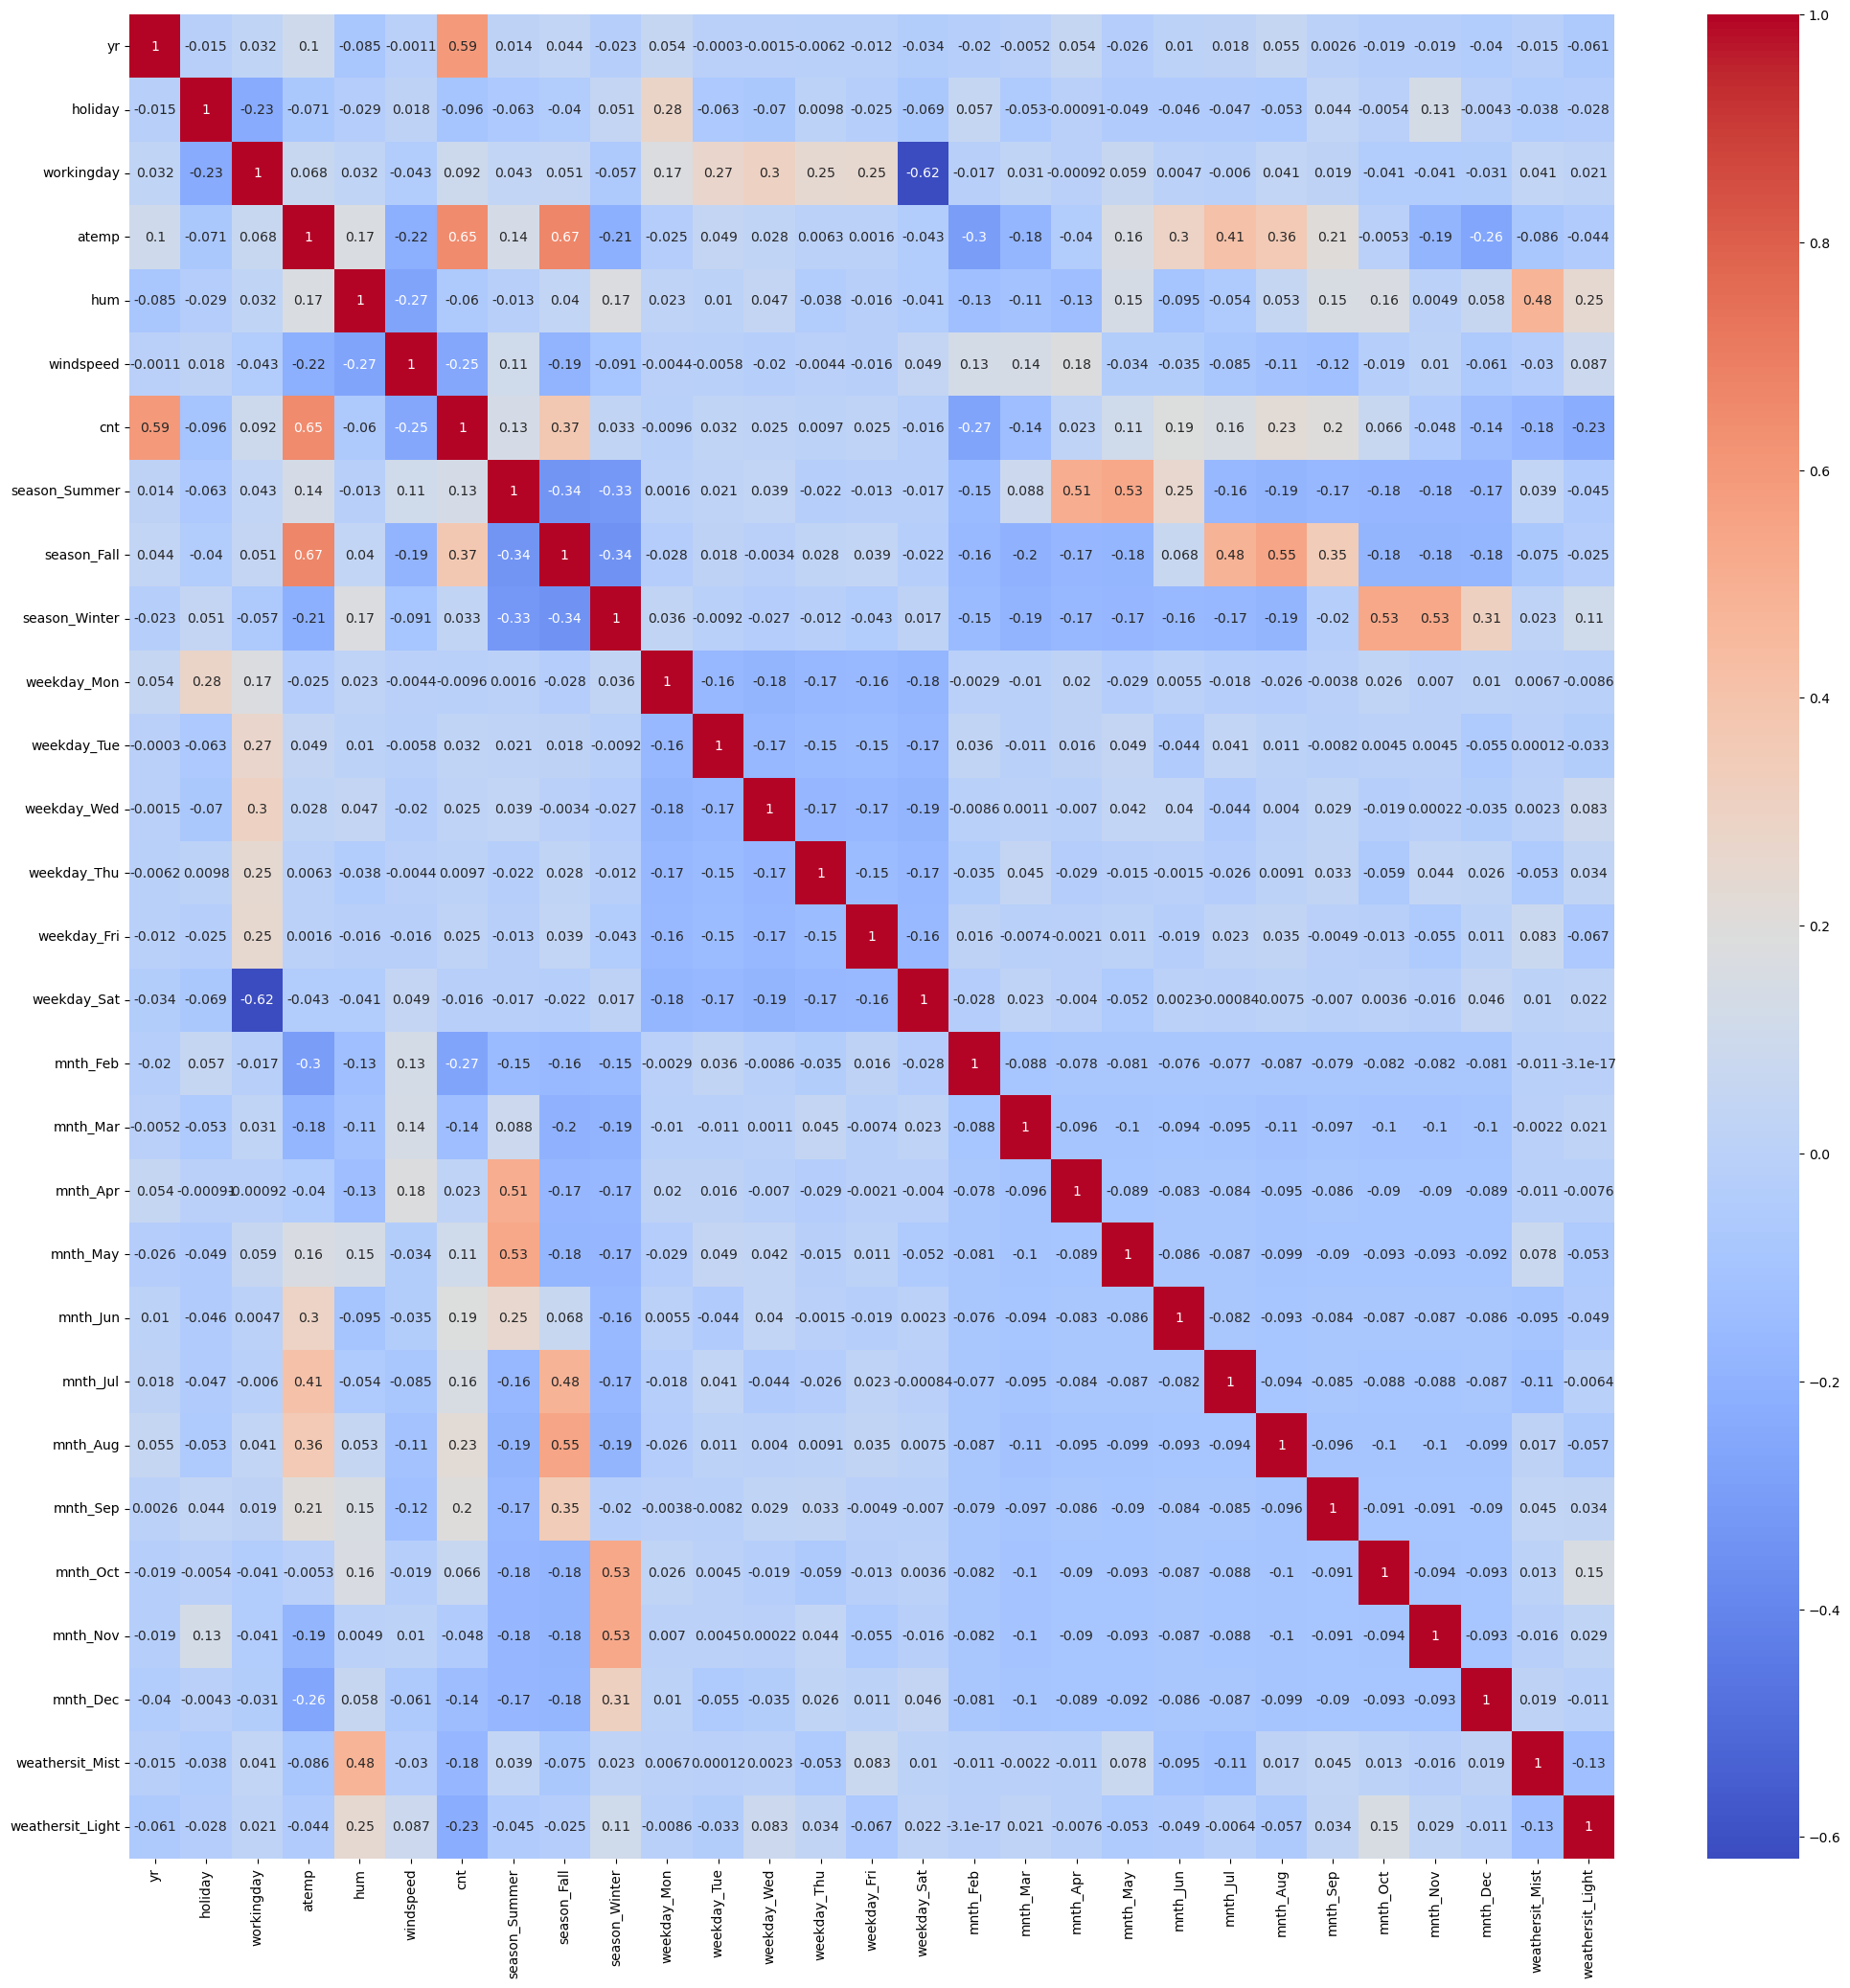

In [356]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (25, 25))
sns.heatmap(df_train.corr(), annot = True, cmap="coolwarm")
plt.show()

### Dividing into X and Y sets for the model building

In [357]:
y_train = df_train.pop('cnt')
X_train = df_train

### Building the first model with all the features

In [358]:
X_train_lm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          4.12e-180
Time:                        01:56:43   Log-Likelihood:                 523.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     482   BIC:                            -873.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1754      0.031  

**NOTE**: This model has an **Adjusted R-squared** value of **84.5%** which seems pretty good. But let's see if we can reduce the number of features and exclude those which are not much relevant in explaining the target variable.

### RFE
Recursive feature elimination

In [359]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15, step=1)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [360]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
col = X_train.columns[rfe.support_]

### Building model using statsmodel, for the detailed statistics

In [361]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

X_train_rfe_lm = sm.add_constant(X_train_rfe)
lr_2 = sm.OLS(y_train, X_train_rfe_lm).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.5
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          8.04e-189
Time:                        01:56:43   Log-Likelihood:                 513.81
No. Observations:                 510   AIC:                            -995.6
Df Residuals:                     494   BIC:                            -927.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1938      0.029  

**Insights**: 
- We reduced the feature from 28 to 15. **Adjusted R-Sq** only changed from **84.3%** to **84.0%**.
- **holiday** is having greater that 0.05 p-value. i.e. holiday is insignificant.

In [362]:
X_train_rfe_sm = X_train_rfe_lm.drop(['const'], axis=1)
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_sm.values, i) for i in range(X_train_rfe_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,atemp,22.71
4,hum,17.79
7,season_Fall,7.67
2,workingday,5.05
5,windspeed,3.85
6,season_Summer,3.37
8,season_Winter,2.88
13,weathersit_Mist,2.15
0,yr,2.04
9,weekday_Sat,1.91


**Insight**
- atemp, hum, season_Fall and workingday have more than 5 VIF. i.e High VIF

Lets do RFE with 10 feature

In [363]:
rfe_10 = RFE(lm, n_features_to_select=10, step=1)             # running RFE
rfe_10 = rfe_10.fit(X_train, y_train)

In [364]:
list(zip(X_train.columns,rfe_10.support_,rfe_10.ranking_))
col_10 = X_train.columns[rfe_10.support_]

In [365]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe_10 = X_train[col_10]

X_train_rfe_10_lm = sm.add_constant(X_train_rfe_10)
lr_3 = sm.OLS(y_train, X_train_rfe_10_lm).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     239.9
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          1.98e-183
Time:                        01:56:44   Log-Likelihood:                 487.06
No. Observations:                 510   AIC:                            -952.1
Df Residuals:                     499   BIC:                            -905.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2747      0.027  

**Insight**: All the variable having p-value < 0.05.

In [366]:
X_train_rfe_10_sm = X_train_rfe_10_lm.drop(['const'], axis=1)
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_10_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_10_sm.values, i) for i in range(X_train_rfe_10_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,10.26
2,atemp,8.55
4,windspeed,3.55
0,yr,2.01
5,season_Summer,1.82
6,season_Winter,1.73
7,mnth_Aug,1.54
8,mnth_Sep,1.30
9,weathersit_Light,1.09
1,holiday,1.04


**Insight**
- **atemp** and **hum** have more than 5 VIF. i.e High
- VIF VIF(hum) > 10 and VIF(atemp) > 8

Lets drop the hum column as it is having highest VIF value

In [367]:
X_train_rfe_10.drop("hum",axis=1,inplace=True)

In [368]:
X_train_rfe_9 = sm.add_constant(X_train_rfe_10)

# Now that we have removed one variable, let's fit the model with 6 variables
lr4 = sm.OLS(y_train, X_train_rfe_9).fit()   
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 14 Mar 2023   Prob (F-statistic):          4.65e-168
Time:                        01:56:44   Log-Likelihood:                 447.96
No. Observations:                 510   AIC:                            -875.9
Df Residuals:                     500   BIC:                            -833.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0858      0.018  

**Insight**: All the p-values are less than 0.05.

In [369]:
X_train_rfe_9_sm = X_train_rfe_9.drop(['const'], axis=1)
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_9_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_9_sm.values, i) for i in range(X_train_rfe_9_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,4.89
3,windspeed,2.95
0,yr,2.00
4,season_Summer,1.80
6,mnth_Aug,1.54
5,season_Winter,1.47
7,mnth_Sep,1.29
8,weathersit_Light,1.06
1,holiday,1.04


**Insight**: All the VIF values are less than 5.

**Insight**:
- All the VIF values are less than 5.
- All the p-values are less than 0.05.
- Feature is reduced from **15** to **9**. Adjusted R-Sq changed from **84.0%** to **79.6%**.
- Feature is reduced from **28** to **9**. Adjusted R-Sq changed from **84.3%** to **79.6%**.

### Residual Analysis of the train data

In [370]:
y_train_cnt = lr4.predict(X_train_rfe_9)

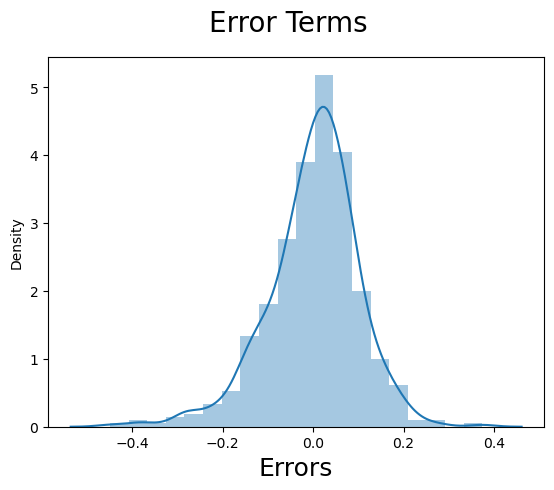

In [371]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
# Plot heading
fig.suptitle('Error Terms', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18) 
plt.show()

The error terms are fairly normally distributed and we can surely live with this. Let's now make predictions on the test-set.

## Making Predictions

### Applying the scaling on the test sets

In [372]:
df_test[numeric_vars] = scaler.transform(df_test[numeric_vars])

### Dividing into X_test and y_test

In [373]:
y_test = df_test.pop('cnt')
X_test = df_test

In [374]:
X_test_rfe_9 = X_test[X_train_rfe_9_sm.columns]
X_test_rfe_9_lm = sm.add_constant(X_test_rfe_9)

In [375]:
y_pred = lr4.predict(X_test_rfe_9_lm)

Text(0, 0.5, 'y_pred')

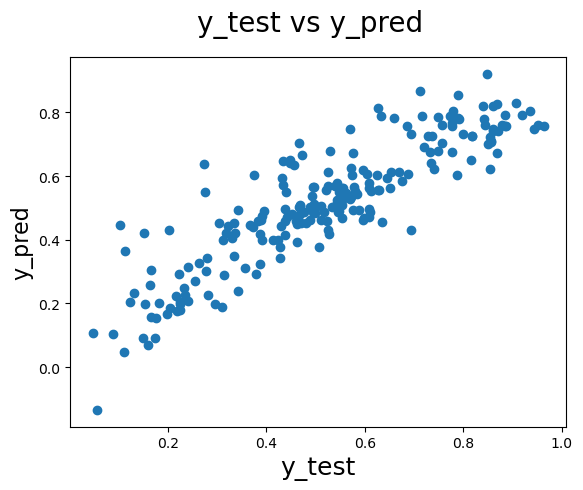

In [376]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 

## R2 Score

In [377]:
# R-Squared for test dataset
r2_test = r2_score(y_test, y_pred)
print('R-Squared for Test dataset: ', round(r2_test, 3))
print('R-Squared for Train dataset: ', round(lr4.rsquared, 3))

R-Squared for Test dataset:  0.775
R-Squared for Train dataset:  0.799


In [378]:
# Adj. R-Squared for test dataset
N = len(X_test)          # sample size
p = len(X_test_rfe_9.columns)    # Number of independent variable
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared for Test dataset: ', r2_test_adj)
print('Adj. R-Squared for Train dataset: ', round(lr4.rsquared_adj, 3))

Adj. R-Squared for Test dataset:  0.765
Adj. R-Squared for Train dataset:  0.796


Thus, for the model with 9 variables, the r-squared on training and test data is about 79.9% and 77.5% respectively. The adjusted r-squared on the train set is about is about 79.6%

In [379]:
lr4.params

const               0.085792
yr                  0.234432
holiday            -0.081725
atemp               0.568000
windspeed          -0.123689
season_Summer       0.087041
season_Winter       0.126595
mnth_Aug            0.053517
mnth_Sep            0.104359
weathersit_Light   -0.246003
dtype: float64


We can see that the equation of our best fitted line is:

$ cnt = 0.085 + 0.234  \times  yr - 0.081  \times  holiday + 0.568 \times atemp - 0.124 \times windspeed + 0.087 \times season_Summer + 0.127 \times season_Winter + 0.054 \times mnth_Aug + 0.104 \times mnth_Sep - 0.246 \times weathersit_Light $


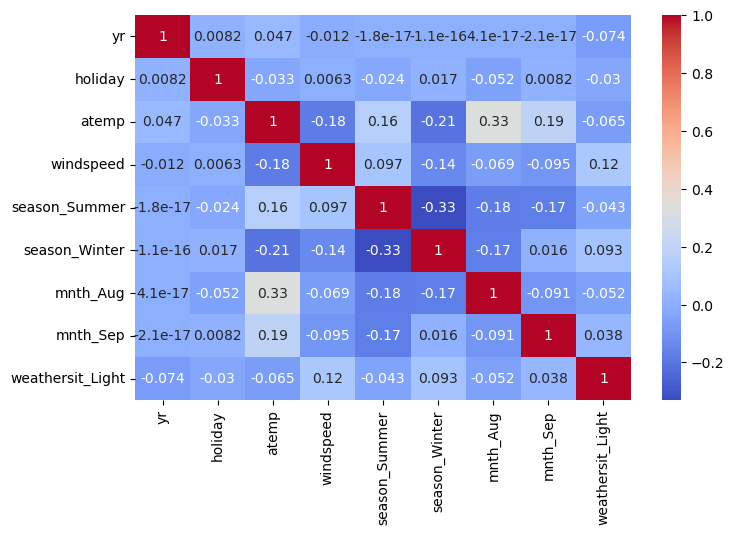

In [380]:
# Figure size
plt.figure(figsize=(8,5))

# Heatmap
sns.heatmap(bike_ds_2[X_test_rfe_9.columns].corr(), cmap="coolwarm", annot=True)
plt.show()

This is the simplest model that we could build. The final predictors seem to have fairly low correlations. 

Thus, the final model consists of the 9 variables mentioned above.One can go ahead with this model and use it for predicting count of daily bike rentals.